Topics: Agents for Geoinformation Processing

*   LangSmith / Debugging (Chapter 1)
*   Langgraph Single Agent (Chapter 2)


# Chapter 1: LangSmith

In [ ]:
!pip install -qU langsmith

In [48]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = ""

# Chapter 2: Langraph/Single Agent

In [ ]:
!pip install langgraph langchain_openai geojson_validator elevenlabs

In [50]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
import geojson_validator

Step 1: Define Our State


In [51]:
# Example adapted from https://huggingface.co/learn/agents-course/unit2/langgraph/first_graph
class LocationState(TypedDict):

    # geojson errors
    geojson_errors: Optional[Dict[str, Any]]

    # analysis and decision about the geojson
    is_valid_geojson: Optional[bool]

    # location data
    location_data: Optional[str]

    # map object
    map: Optional[Any]

    # processing metadata
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

    # number of cities
    number_of_cities: Optional[str]

    # output message, after the validation of the geojson
    output_message: Optional[str]

    # speech file
    speech_file_path: Optional[str]

In [58]:
import folium
import json
from openai import OpenAI
from IPython.display import Audio, display
#from PIL import Image
import PIL.Image
from pathlib import Path
import base64
import io

#model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)


#### NODES

def generate_location(state: LocationState):
    """Generate geojson for cities close to Dresden"""

    n_cities = state["number_of_cities"]

    prompt = """

    You are an assistant specialized into returning information about the closest cities to the city of Dresden, Germany.

    The output should be formatted as geojson. Return their coordinates and the distance in km between these cities.

    Do not include Dresden in the list of generated cities.

    Do not add any additional text to the output. The ouput should start and finish with {} as expected of a properly-formatted geojson.

    Do not add ```json.

    Key for cities: 'city'

    Key for distance: 'distance_km'

    Number of cities:
    """

    user_input = prompt + str(n_cities)

    # Call the LLM
    message = [HumanMessage(content=user_input)]
    response = model.invoke(message)

    print("*** Generated geojson: ", response)

    # Update messages for tracking
    new_message = state.get("messages", []) + [
        {"role": "user", "content": user_input},
        {"role": "agent", "content": response.content}
    ]

    # update the state and the message
    return {"location_data": response.content,  "messages": new_message }

def check_location_data(state: LocationState):
    """Check the validity of the geojson returned by the LLM"""

    geojson_input = state["location_data"]
    print("*** Testing the geojson ...")

    geojson_errors = {}

    # Check the validity of the geojson
    try:
      data = json.loads(geojson_input) # validity of json
      print(data)
      try:
        errors = geojson_validator.validate_structure(data)  # validity of geojson
        if not errors:
          is_valid_geojson = True
          geojson_errors = {}
        else:
          is_valid_geojson = False
          geojson_errors = errors
      except:
        is_valid_geojson = False
    except json.JSONDecodeError as e:
        print("Invalid JSON syntax", e)
        is_valid_geojson = False
        geojson_errors = e

    # return state updates
    return {
        "is_valid_geojson": is_valid_geojson,
        "geojson_errors": geojson_errors,
        "output_message": "The LLM-generated geojson for %s cities is valid" % state['number_of_cities'] if is_valid_geojson else "The LLM-generated geojson is not valid"
    }


def show_on_map(state: LocationState):
    """Show the cities on a map """

    print("*** Creating the map...")

    geojson_input = state["location_data"]

    m = folium.Map(location=(51.05, 13.73)) # for alternatives, see https://leafmap.org/get-started/

    folium.GeoJson(geojson_input,
                  tooltip=folium.GeoJsonTooltip(fields=["city", "distance_km"]),
#                  popup=folium.GeoJsonPopup(fields=["city", "distance_km"])
                  ).add_to(m)

    folium.Marker(
        location=[51.049259, 13.73836],
        tooltip="Dresden",
        popup="Dresden",
        icon=folium.Icon(color="green"),
    ).add_to(m)

    display(m)
    return {"map": m}

def print_message(state: LocationState):
  """ prints the error message as text """

  print("*** Error message: ", state["output_message"])

  client = OpenAI()

  prompt = """
  Generate an image illustrating the message given as input. The image should be as nice as possible.
  Message:
  """
  # see https://platform.openai.com/docs/guides/image-generation?image-generation-model=gpt-image-1
  result = client.images.generate(
      model="gpt-image-1",
      prompt=prompt+state["output_message"]
  )

  image_base64 = result.data[0].b64_json
  image_bytes = base64.b64decode(image_base64)

  im_path = "/content/img.png"

  # Save the image to a file
  with open(im_path, "wb") as f:
      f.write(image_bytes)

  img = PIL.Image.open(im_path)
  display(img)

  return {}


def play_audio(state: LocationState):
     """ communicate the results of the validation as audio """
     print("*** Storing the audio file...")
     client = OpenAI()
     speech_file_path = "/content/speech.mp3" # https://platform.openai.com/docs/guides/text-to-speech

     with client.audio.speech.with_streaming_response.create(
        model="gpt-4o-mini-tts",
        voice="coral",
        input=state["output_message"],
        instructions="Speak in a cheerful and positive tone.",
    ) as response:
        response.stream_to_file(speech_file_path) # store the file first

     display(Audio(speech_file_path, rate=24000, autoplay=True)) # play the stored audio

     return {"speech_file_path": speech_file_path}

In [53]:
## LOGIC
def route_geojson_data(state: LocationState) -> str:
    """Determine the next step based on the validity of the geojson"""
    if state["is_valid_geojson"]:
        print("The geojson is valid")
        return "valid"
    else:
        print("The geojson is not valid")
        return "invalid"

In [59]:
# Create the graph
graph = StateGraph(LocationState)

# Add nodes
graph.add_node("generate_data", generate_location)
graph.add_node("check_data", check_location_data)
graph.add_node("show_map", show_on_map)
graph.add_node("play_audio", play_audio)
graph.add_node("print_message", print_message)

# Start the edges
graph.add_edge(START, "generate_data")
# Add edges - defining the flow
graph.add_edge("generate_data", "check_data")

# Add conditional branching from classify_email
graph.add_conditional_edges(
    "check_data",
    route_geojson_data,
    {
        "valid": "play_audio",
        "invalid": "print_message"
    }
)

# Add the final edges
graph.add_edge("print_message", END)
graph.add_edge("play_audio", "show_map")
graph.add_edge("show_map", END)

# Compile the graph
compiled_graph = graph.compile()

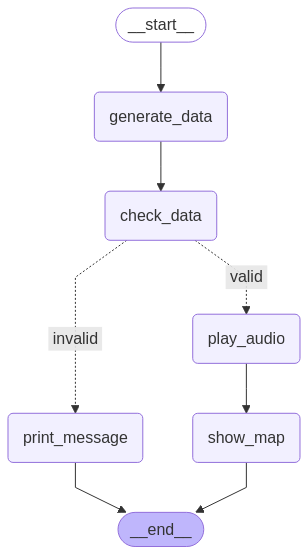

In [55]:
from IPython.display import Image, display, Audio

try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


Processing the user input...
*** Generated geojson:  content='{\n    "cities": [\n        {\n            "city": "Leipzig",\n            "coordinates": [51.3397, 12.3731],\n            "distance_km": 116\n        },\n        {\n            "city": "Chemnitz",\n            "coordinates": [50.8278, 12.9214],\n            "distance_km": 77\n        },\n        {\n            "city": "Magdeburg",\n            "coordinates": [52.1205, 11.6276],\n            "distance_km": 235\n        },\n        {\n            "city": "Prague",\n            "coordinates": [50.0755, 14.4378],\n            "distance_km": 150\n        }\n    ]\n}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 156, 'prompt_tokens': 127, 'total_tokens': 283, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.

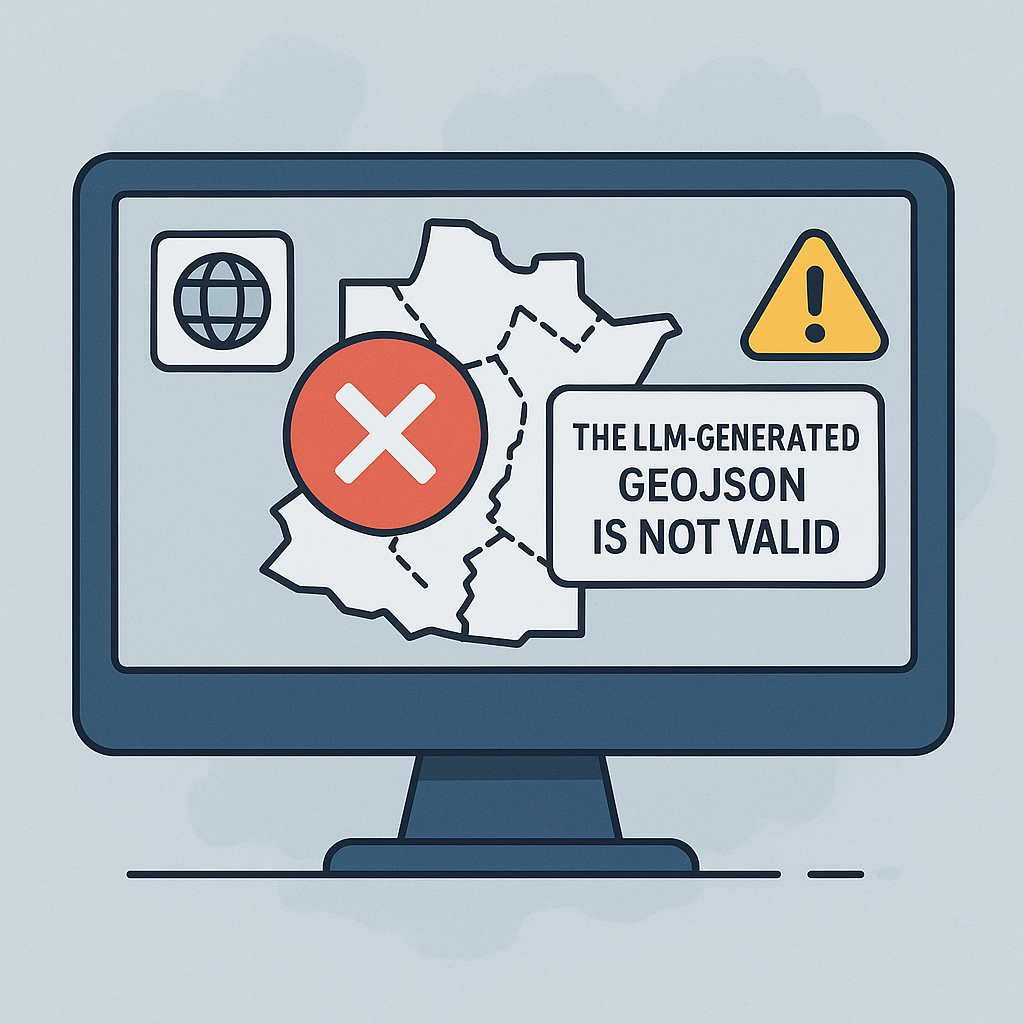

In [60]:
print("\nProcessing the user input...")
result = compiled_graph.invoke({
    "geojson_errors": None,
    "is_valid_geojson": None,
    "location_data": None,
    "map": None,
    "messages": [],
    "number_of_cities": 4,
    "output_message": None,
    "speech_file_path": None,
})

In [61]:
client = OpenAI()
speech_file_path = "/content/speech.mp3"

# https://platform.openai.com/docs/guides/text-to-speech
with client.audio.speech.with_streaming_response.create(
  model="gpt-4o-mini-tts",
  voice="coral",
  input="Podcast 01 of Geoinformationdienste at TU Dresden in the Summer 2025",
  instructions="Speak in a cheerful and positive tone.",
) as response:
  response.stream_to_file(speech_file_path)
display(Audio(speech_file_path, rate=24000, autoplay=True))

# Project Work

* Exercice 01: Get an API key from one large language model of your [choice](https://python.langchain.com/docs/integrations/chat/#all-chat-models) (openAI, deepseek, gemini, ...)

* Exercice 02: Register on LangSmith and [get an API key](https://docs.smith.langchain.com/observability)

* Exercice 03: Go through the [Langgraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/introduction/). It covers basics such as node, edges, states/state customization and memory addition

* Exercice 04: Build a langgraph agent that has two components: a llm and a tool. The tool counts how many place names there is in a portion of text. The place names are identified by the LLM and then sent to the tool that does the counting [Yes, the counting could be done by a language model as well, but should be done in a tool - to learn about the general structure and the connection between the components]. Example of portion of text, from [Wikipedia](https://en.wikipedia.org/wiki/Dresden): "*Dresden is the capital city of the German state of Saxony and its second most populous city after Leipzig. It is the 12th most populous city of Germany, the fourth largest by area (after Berlin, Hamburg, and Cologne), and the third-most populous city in the area of former East Germany, after Berlin and Leipzig. Dresden's urban area comprises the towns of Freital, Pirna, Radebeul, Meissen, Coswig, Radeberg, and Heidenau and has around 790,000 inhabitants. The Dresden metropolitan area has approximately 1.34 million inhabitants.*"

* Exercice 05: Think about and draft a first version of the architecture for your project scenario on a piece of paper (agent, their components, their connections).

The notebook has only scratched the surface of Langgraph and more functionalities can be found in the [Langgraph documentation](https://langchain-ai.github.io/langgraph/tutorials/introduction/).

Happy coding!